In this notebook we attempt to predict the angular velocity and air tube motion from G4D.

In [1]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.linear_model import LinearRegression

from aux import make_extended_predictor_matrix, save_table
from data import DataLoader
import lin_fit
from plot import set_font_size, unity_line

import CONFIG as C
import LOCAL_SETTINGS as L

In [2]:
def plot_overlay(t, y_0, y_1, kwargs_0, kwargs_1, fig_size=(15, 4)):
    
    fig, ax_0 = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
    ax_1 = ax_0.twinx()
    
    ax_0.plot(t, y_0, **kwargs_0)
    ax_1.plot(t, y_1, **kwargs_1)
    
    return ax_0, ax_1

In [3]:
from db import make_session, d_models

FILT = [d_models.Trial.walking_threshold != None]

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

In [4]:
closed_mask = [trial.expt == 'closed_loop' for trial in trials]
driven_mask = [trial.expt == 'driven_random' for trial in trials]
no_air_mask = [trial.expt == 'no_air' for trial in trials]

c_dict = {'closed_loop': 'k', 'driven_random': 'b', 'no_air': 'r'}

colors = [c_dict[trial.expt] for trial in trials]

In [5]:
for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx='0', vel_filt=None)

Loading data for trial 1/44 (20170310.Fly2.6)
Loading clean data from file "clean_0.csv"...
Loading data for trial 2/44 (20170310.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 3/44 (20170310.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 4/44 (20170313.Fly1.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 5/44 (20170313.Fly1.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 6/44 (20170313.Fly1.3)
Loading clean data from file "clean_0.csv"...
Loading data for trial 7/44 (20170313.Fly1.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 8/44 (20170313.Fly1.8)
Loading clean data from file "clean_0.csv"...
Loading data for trial 9/44 (20170313.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 10/44 (20170313.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 11/44 (20170313.Fly3.3)
Loading clean data from file "cl

### Predict angular velocities using G4D

In [6]:
WINDOWS = {'g4d': (1, 6)}
rslts = {'v_ang': []}

for trial in trials:
    rslt = lin_fit.regress(trial=trial, targ='v_ang', preds=('g4d',), windows=WINDOWS, valid='all')
    
    # get fraction of time fly is pointed upwind rel to air tube
    frac_uw = np.mean(np.abs(trial.dl.air) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts['v_ang'].append(rslt)

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


### Show R2 and G4D coefs for all trials

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11d5c3c18>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11f8fd2b0>], dtype=object)

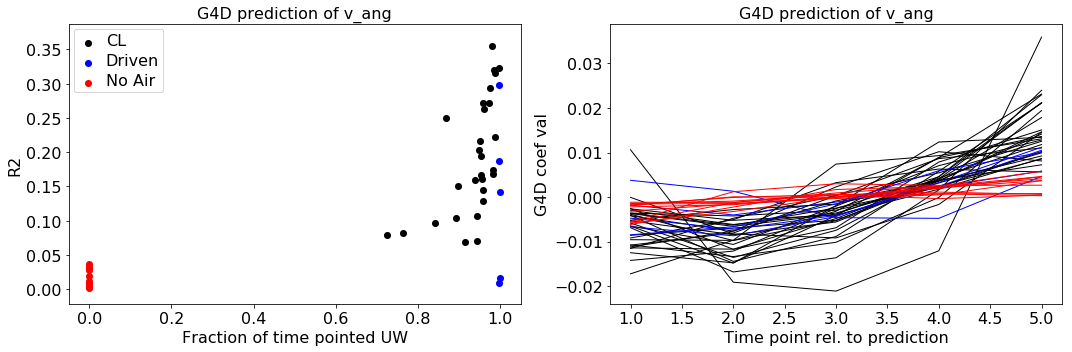

In [7]:
def plot_r2s_vs_frac_uw(targ):

    fig, axs = plt.subplots(1, 2, figsize=(15, 5), tight_layout=True)

    r2s = np.array([rslt.r2 for rslt in rslts[targ]])
    fracs_uw = np.array([rslt.details['frac_uw'] for rslt in rslts[targ]])

    axs[0].scatter(fracs_uw[closed_mask], r2s[closed_mask], s=50, c=c_dict['closed_loop'], lw=0)
    axs[0].scatter(fracs_uw[driven_mask], r2s[driven_mask], s=50, c=c_dict['driven_random'], lw=0)
    axs[0].scatter(fracs_uw[no_air_mask], r2s[no_air_mask], s=50, c=c_dict['no_air'], lw=0)

    axs[0].set_xlabel('Fraction of time pointed UW')
    axs[0].set_ylabel('R2')
    axs[0].set_title('G4D prediction of {}'.format(targ))
    axs[0].legend(['CL', 'Driven', 'No Air'])

    axs[0].set_xlim(-0.05, 1.05)
    ts_coef = np.arange(*WINDOWS['g4d'])

    for rslt, trial in zip(rslts[targ], trials):
        if rslt.coefs is not None:
            axs[1].plot(ts_coef, rslt.coefs['g4d'], color=c_dict[trial.expt], lw=1)

    axs[1].set_xlabel('Time point rel. to prediction')
    axs[1].set_ylabel('{} coef val'.format('G4D'))
    axs[1].set_title('G4D prediction of {}'.format(targ))

    for ax in axs:
        
        set_font_size(ax, 16)
        
    return axs
        
plot_r2s_vs_frac_uw('v_ang')

### Predict air tube using G4D

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1221d3f98>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x122252518>], dtype=object)

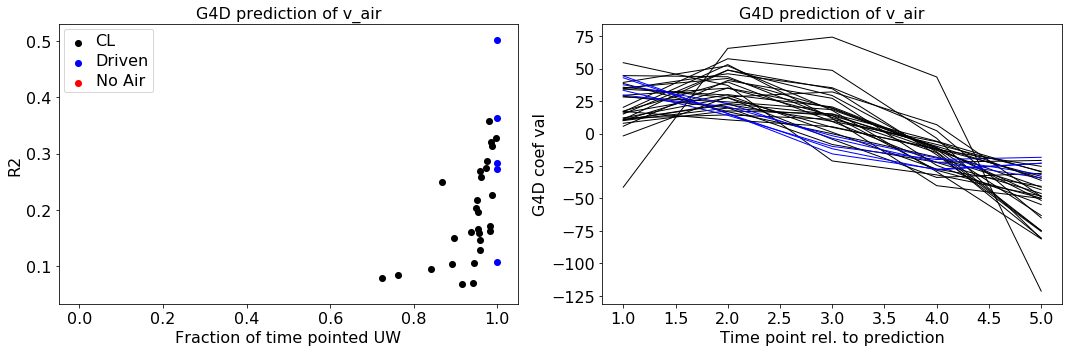

In [8]:
rslts['v_air'] = []

for trial in trials:
    if trial.expt == 'no_air':
        valid = 'none'
    else:
        valid = 'all'
        
    rslt = lin_fit.regress(trial=trial, targ='v_air', preds=('g4d',), windows=WINDOWS, valid=valid)
    
    # get fraction of time fly is pointed upwind rel to air tube
    if not np.all(np.isnan(trial.dl.air)):
        valid_mask = ~np.isnan(trial.dl.air)
        frac_uw = np.mean(np.abs(trial.dl.air[valid_mask]) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts['v_air'].append(rslt)
    
plot_r2s_vs_frac_uw('v_air')

In [9]:
def plot_example_v_ang_prediction(trial_name, fig_size=(15, 5), color='g'):
    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
    
    trial_idx = [trial.name for trial in trials].index(trial_name)
    rslt = rslts['v_ang'][trial_idx]
    
    ts = trial.dl.t
    
    ax.plot(ts, rslt.ys, lw=2, color='k')
    ax.plot(ts, rslt.ys_pred, lw=2, color=color)
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('v_ang')
    ax.set_title('Predicting v_ang from DAN activity')
    ax.legend(['True', 'Predicted'])

    set_font_size(ax, 16)
    
    return ax

def plot_example_air_tube_prediction(trial_name, fig_size=(15, 5), color='g'):
    fig, ax = plt.subplots(1, 1, figsize=fig_size, tight_layout=True)
    
    trial_idx = [trial.name for trial in trials].index(trial_name)
    rslt = rslts['v_air'][trial_idx]
    
    ts = trial.dl.t
    
    ax.plot(ts, rslt.ys, lw=2, color='k')
    ax.plot(ts, rslt.ys_pred, lw=2, color=color)
    
    ax.set_xlabel('t (s)')
    ax.set_ylabel('v_air (deg/s)')
    ax.set_title('Predicting v_air from DAN activity')
    ax.legend(['True', 'Predicted'])

    set_font_size(ax, 16)
    
    return ax

### G4D prediction of angular/air-tube velocity in example Closed Loop trial

(90, 150)

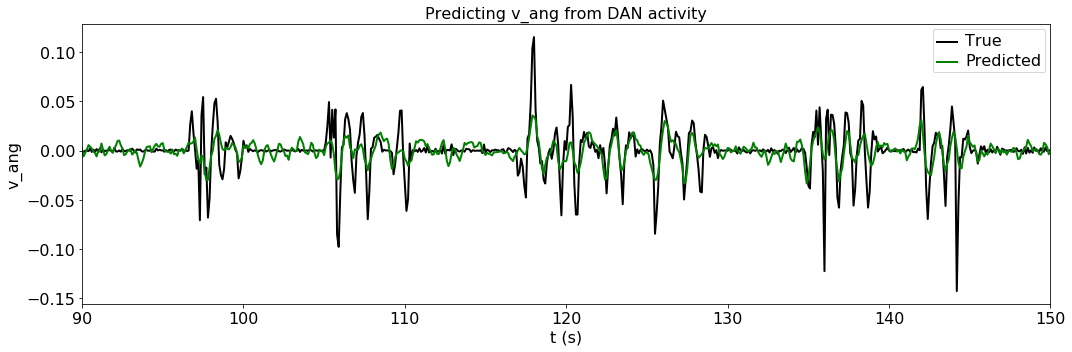

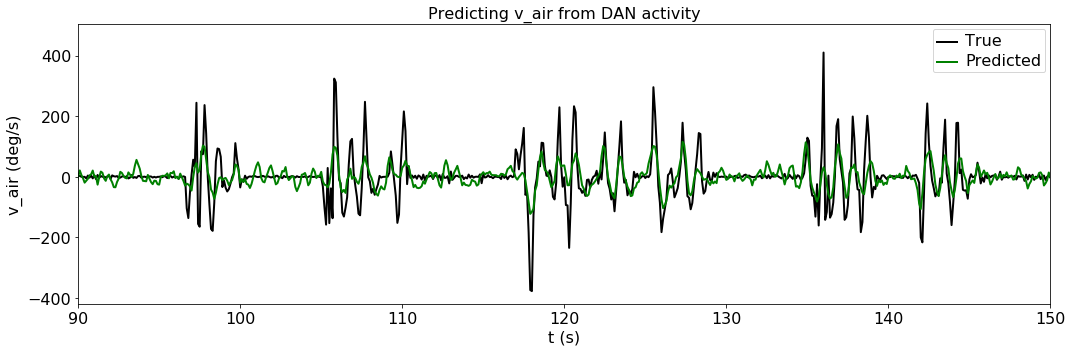

In [10]:
ax = plot_example_v_ang_prediction('20170428.Fly5.1', color='g')
ax.set_xlim(90, 150)

ax = plot_example_air_tube_prediction('20170428.Fly5.1', color='g')
ax.set_xlim(90, 150)

### G4D prediction of angular velocity vs. air-tube velocity in random air-tube section of driven random trial

(-200, 200)

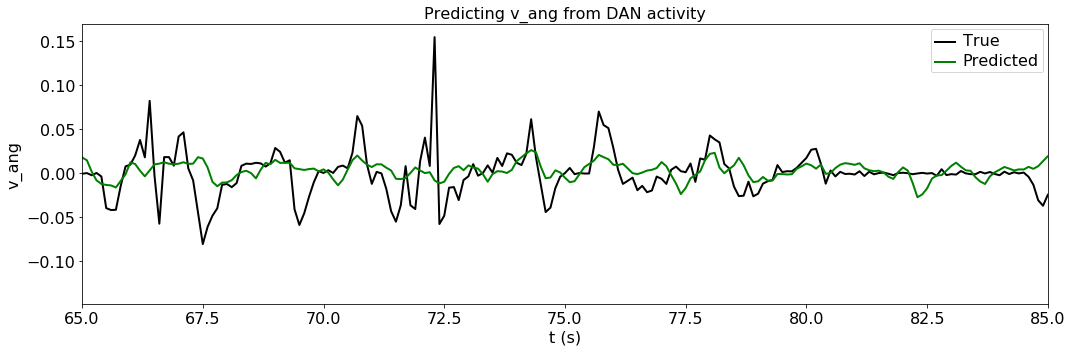

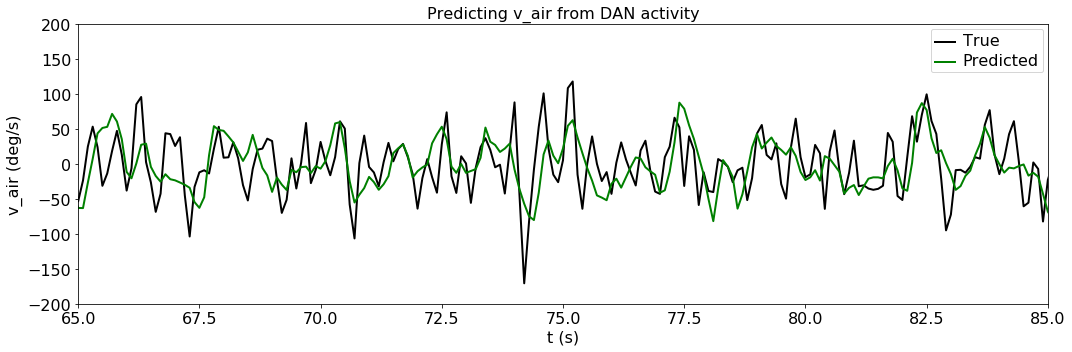

In [11]:
ax = plot_example_v_ang_prediction('20170428.Fly5.5')
ax.set_xlim(65, 85)

ax = plot_example_air_tube_prediction('20170428.Fly5.5')
ax.set_xlim(65, 85)
ax.set_ylim(-200, 200)

### Show results table

In [12]:
df_data = []

for tr_ctr, trial in enumerate(trials):
    df_data.append({
        'Trial': trial.name,
        'Expt': trial.expt,
        'Frac UW': rslts['v_ang'][tr_ctr].details['frac_uw'],
        'R2 (v_ang)': rslts['v_ang'][tr_ctr].r2,
        'R2 (air_tube)': rslts['v_air'][tr_ctr].r2,
    })
    
columns = ['Trial', 'Expt', 'Frac UW', 'R2 (v_ang)', 'R2 (air_tube)']
df = pd.DataFrame(df_data, columns=columns)
df

,Trial,Expt,Frac UW,R2 (v_ang),R2 (air_tube)
0,20170310.Fly2.6,closed_loop,0.914333,0.068537,0.068578
1,20170310.Fly3.1,closed_loop,0.842000,0.096227,0.094923
2,20170310.Fly3.2,closed_loop,0.955000,0.161312,0.159767
3,20170313.Fly1.1,closed_loop,0.959000,0.145297,0.146558
4,20170313.Fly1.2,closed_loop,0.896333,0.150871,0.149522
5,20170313.Fly1.3,closed_loop,0.949000,0.203708,0.202607
6,20170313.Fly1.4,closed_loop,0.959000,0.271305,0.268570
7,20170313.Fly1.8,closed_loop,0.982667,0.174720,0.170593
8,20170313.Fly3.1,closed_loop,0.953667,0.195055,0.196876
9,20170313.Fly3.2,closed_loop,0.985000,0.319754,0.321401


In [13]:
save_table(os.path.join(L.TABLE_DIR, 'g4_ang_air.csv'), df)

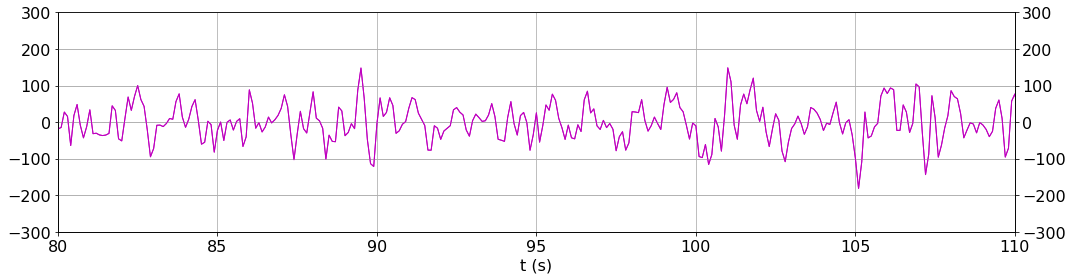

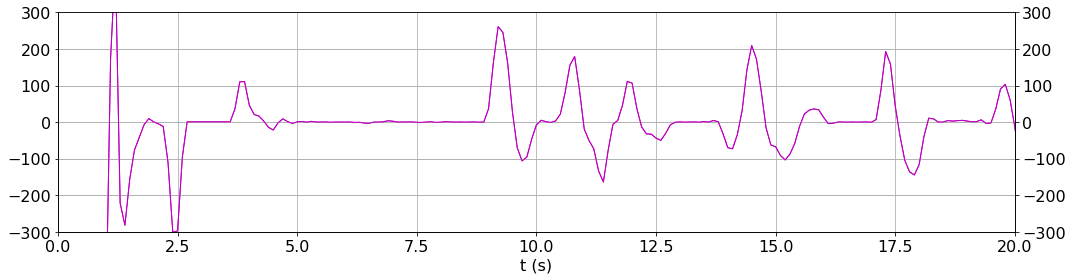

In [14]:
TRIAL_EX = '20170428.Fly5.5'
trial_ex = [tr for tr in trials if tr.name == TRIAL_EX][0]

ax_0, ax_1 = plot_overlay(
    trial_ex.dl.t,
    trial_ex.dl.ddt_air,
    trial_ex.dl.ddt_air,
    kwargs_0={'color': 'm', 'lw': 1},
    kwargs_1={'color': 'm', 'lw': 1})

ax_0.set_xlim(80, 110)
#ax_0.set_xlim(190, 220)
ax_0.set_xlabel('t (s)')

for ax in [ax_0, ax_1]:
    ax.set_ylim(-300, 300)
    ax.grid()
    set_font_size(ax, 16)
    
ax_0, ax_1 = plot_overlay(
    trial_ex.dl.t,
    trial_ex.dl.ddt_air,
    trial_ex.dl.ddt_air,
    kwargs_0={'color': 'm', 'lw': 1},
    kwargs_1={'color': 'm', 'lw': 1})

ax_0.set_xlim(0, 20)
#ax_0.set_xlim(190, 220)
ax_0.set_xlabel('t (s)')

for ax in [ax_0, ax_1]:
    ax.set_ylim(-300, 300)
    ax.grid()
    set_font_size(ax, 16)

Show correlations between R^2s.

In [15]:
df.corr()

,Frac UW,R2 (v_ang),R2 (air_tube)
Frac UW,1.00000,0.702620,0.561390
R2 (v_ang),0.70262,1.000000,0.763092
R2 (air_tube),0.56139,0.763092,1.000000


### Example overlay of true and G4D-predicted v_ang/v_air in Closed Loop trial with large R2 (20170428.Fly5.1)

(90, 150)

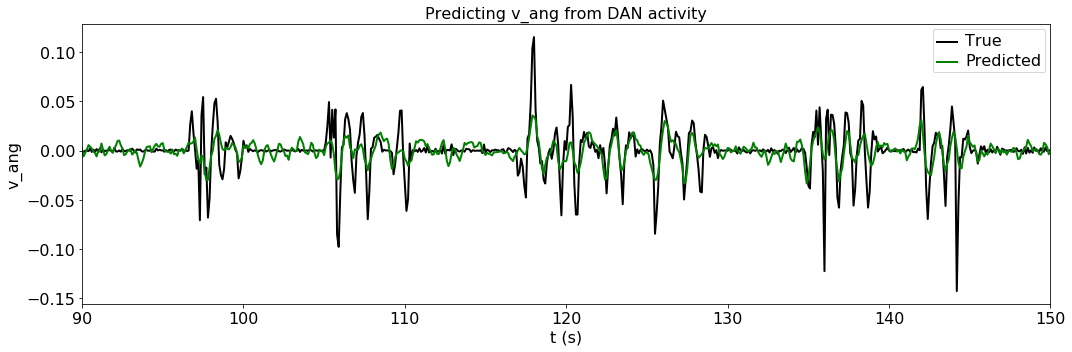

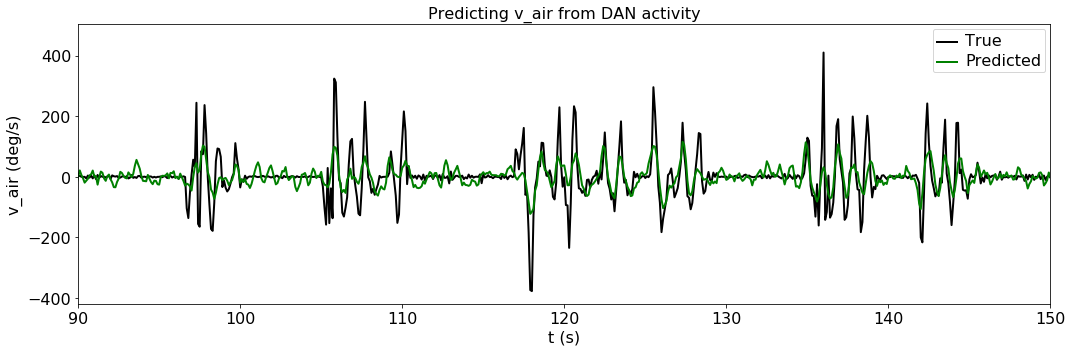

In [16]:
ax = plot_example_v_ang_prediction('20170428.Fly5.1', color='g')
ax.set_xlim(90, 150)

ax = plot_example_air_tube_prediction('20170428.Fly5.1', color='g')
ax.set_xlim(90, 150)

(170, 230)

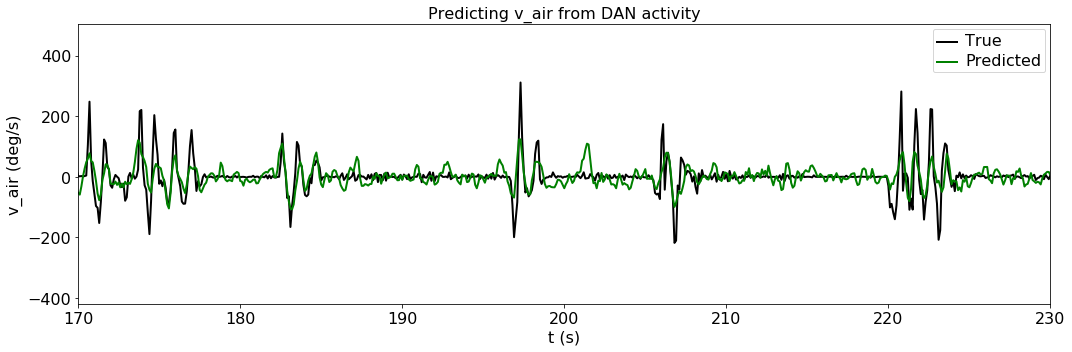

In [17]:
ax = plot_example_air_tube_prediction('20170428.Fly5.1', color='g')
ax.set_xlim(170, 230)

### Example overlay of true and G4D-predicted v_ang/v_air in Driven Random trial with large R2 (20170428.Fly1.5)

(-200, 200)

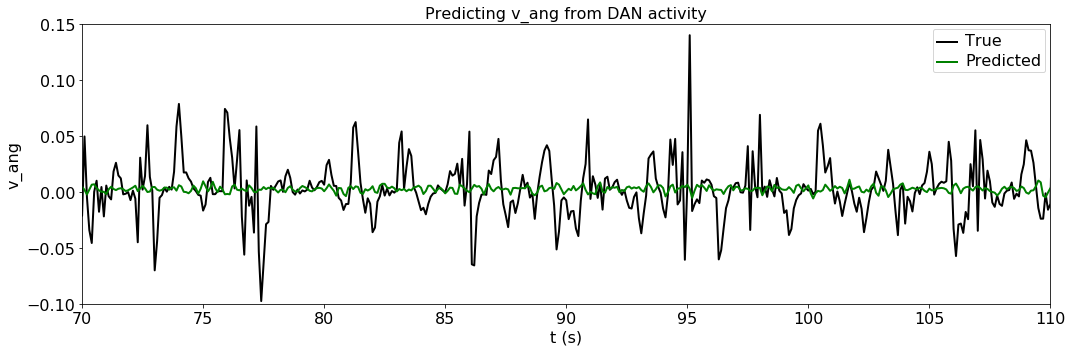

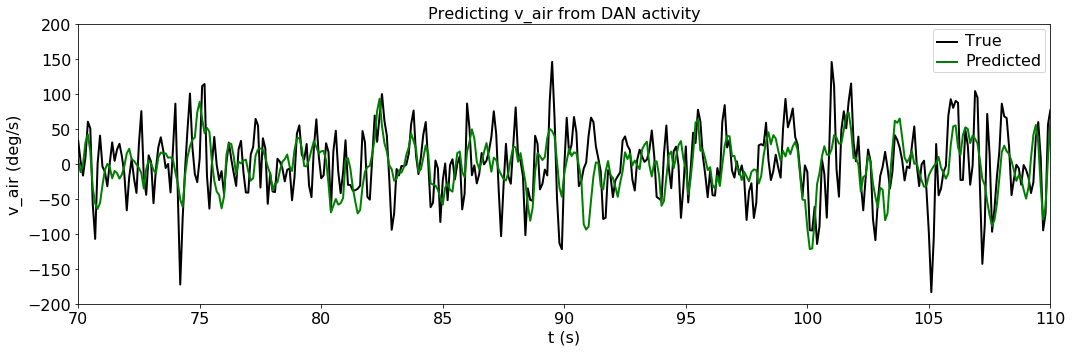

In [18]:
ax = plot_example_v_ang_prediction('20170428.Fly1.5', color='g')
ax.set_xlim(70, 110)
ax.set_ylim(-.1, .15)

ax = plot_example_air_tube_prediction('20170428.Fly1.5', color='g')
ax.set_xlim(70, 110)
ax.set_ylim(-200, 200)

Note, however, that we can't directly compare the $R^2$s for v_ang vs. v_air, since these two variables have different autocorrelation statistics, so even though it seems like v_air is predicted much better than v_ang, the comparison is not completely fair. To make a fair comparison we do the reverse analysis, predicting G4D from each of these variables. Since we're predicting the same variable but using two different predictors, we can quantitatively say whether one predictors explains more G4D variance than another by directly comparing them.

### Predict G4D using v_ang

In [19]:
WINDOWS = {'v_ang': (-5, 0)}
rslts = {'v_ang': {}}

for trial in trials:
    rslt = lin_fit.regress(trial=trial, targ='g4d', preds=('v_ang',), windows=WINDOWS, valid='all')
    
    # get fraction of time fly is pointed upwind rel to air tube
    frac_uw = np.mean(np.abs(trial.dl.air) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts['v_ang'][trial.name] = rslt

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


### Predict G4D using v_air

In [20]:
WINDOWS = {'v_air': (-5, 0)}
rslts['v_air'] = {}

for trial in trials:
    rslt = lin_fit.regress(trial=trial, targ='g4d', preds=('v_air',), windows=WINDOWS, valid='all')
    
    # get fraction of time fly is pointed upwind rel to air tube
    frac_uw = np.mean(np.abs(trial.dl.air) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts['v_air'][trial.name] = rslt

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


### Show table of results

,trial,expt,v_ang,v_air
19,20170428.Fly1.5,driven_random,0.001610,0.090373
23,20170428.Fly2.4,driven_random,0.005530,0.019233
27,20170428.Fly5.4,driven_random,0.095296,0.125536
28,20170428.Fly5.5,driven_random,0.181800,0.218985
41,20170428.Fly1.4,driven_random,0.051332,0.101333


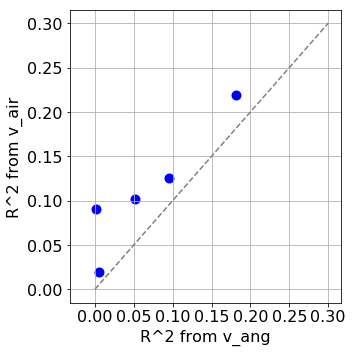

In [21]:
df_cols = ['trial', 'expt', 'v_ang', 'v_air']
df_data = []

for trial in trials:
    df_data.append({
        'trial': trial.name,
        'expt': trial.expt,
        'v_ang': rslts['v_ang'][trial.name].r2,
        'v_air': rslts['v_air'][trial.name].r2,
    })
    
df = pd.DataFrame(df_data, columns=df_cols)
df_driven = df[df.expt == 'driven_random']

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

ax.scatter(df_driven.v_ang, df_driven.v_air, s=100, c='b', lw=0, zorder=0)
unity_line(ax, 0, .3, color='gray', ls='--')
ax.grid(zorder=-1)

ax.set_xlabel('R^2 from v_ang')
ax.set_ylabel('R^2 from v_air')

set_font_size(ax, 16)

df_driven

As we can see here, the G4D $R^2$s aren't super large, but v_air appears to generally be a better predictor.

### Predict ddt_G4D using v_ang

In [22]:
WINDOWS = {'v_ang': (-5, 0)}
rslts_ddt = {'v_ang': {}}

for trial in trials:
    rslt = lin_fit.regress(trial=trial, targ='ddt_g4d', preds=('v_ang',), windows=WINDOWS, valid='all')
    
    # get fraction of time fly is pointed upwind rel to air tube
    frac_uw = np.mean(np.abs(trial.dl.air) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts_ddt['v_ang'][trial.name] = rslt

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


### Predict ddt_G4D using v_air

In [23]:
WINDOWS = {'v_air': (-5, 0)}
rslts_ddt['v_air'] = {}

for trial in trials:
    rslt = lin_fit.regress(trial=trial, targ='ddt_g4d', preds=('v_air',), windows=WINDOWS, valid='all')
    
    # get fraction of time fly is pointed upwind rel to air tube
    frac_uw = np.mean(np.abs(trial.dl.air) < 90)
    rslt.details['frac_uw'] = frac_uw
    
    rslts_ddt['v_air'][trial.name] = rslt

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


### Show table of results

,trial,expt,v_ang,v_air
19,20170428.Fly1.5,driven_random,0.013401,0.273194
23,20170428.Fly2.4,driven_random,0.018977,0.080785
27,20170428.Fly5.4,driven_random,0.171540,0.319511
28,20170428.Fly5.5,driven_random,0.252271,0.464003
41,20170428.Fly1.4,driven_random,0.150326,0.266220


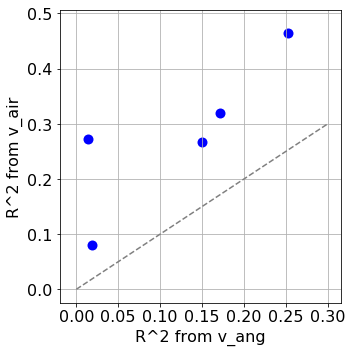

In [24]:
df_cols = ['trial', 'expt', 'v_ang', 'v_air']
df_data = []

for trial in trials:
    df_data.append({
        'trial': trial.name,
        'expt': trial.expt,
        'v_ang': rslts_ddt['v_ang'][trial.name].r2,
        'v_air': rslts_ddt['v_air'][trial.name].r2,
    })
    
df = pd.DataFrame(df_data, columns=df_cols)
df_driven = df[df.expt == 'driven_random']

fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)

ax.scatter(df_driven.v_ang, df_driven.v_air, s=100, c='b', lw=0, zorder=0)
unity_line(ax, 0, .3, color='gray', ls='--')
ax.grid(zorder=-1)

ax.set_xlabel('R^2 from v_ang')
ax.set_ylabel('R^2 from v_air')

set_font_size(ax, 16)

df_driven

Here we show the time derivative of G4D, which is again predicted better by v_air than v_ang.

### Example plots

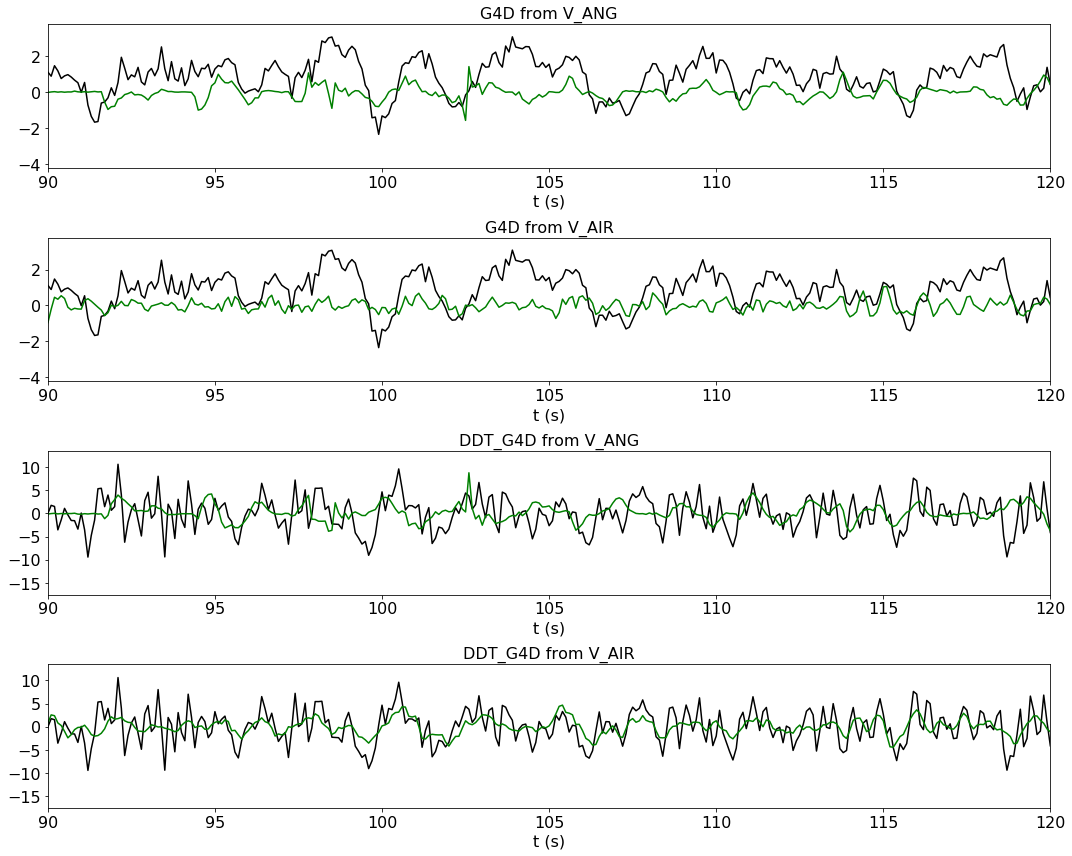

In [25]:
TRIAL_EX = '20170428.Fly5.5'
trial_ex = [tr for tr in trials if tr.name == TRIAL_EX][0]

fig, axs = plt.subplots(4, 1, figsize=(15, 12), tight_layout=True)

# plot G4D predicted by v_ang
axs[0].plot(trial_ex.dl.t, rslts['v_ang'][TRIAL_EX].ys, color='k')
axs[0].plot(trial_ex.dl.t, rslts['v_ang'][TRIAL_EX].ys_pred, color='g')
axs[0].set_title('G4D from V_ANG')

# plot G4D predicted by v_air
axs[1].plot(trial_ex.dl.t, rslts['v_air'][TRIAL_EX].ys, color='k')
axs[1].plot(trial_ex.dl.t, rslts['v_air'][TRIAL_EX].ys_pred, color='g')
axs[1].set_title('G4D from V_AIR')

# plot ddt_G4D predicted by v_ang
axs[2].plot(trial_ex.dl.t, rslts_ddt['v_ang'][TRIAL_EX].ys, color='k')
axs[2].plot(trial_ex.dl.t, rslts_ddt['v_ang'][TRIAL_EX].ys_pred, color='g')
axs[2].set_title('DDT_G4D from V_ANG')

# plot ddt_G4D predicted by v_air
axs[3].plot(trial_ex.dl.t, rslts_ddt['v_air'][TRIAL_EX].ys, color='k')
axs[3].plot(trial_ex.dl.t, rslts_ddt['v_air'][TRIAL_EX].ys_pred, color='g')
axs[3].set_title('DDT_G4D from V_AIR')

for ax in axs:
    ax.set_xlim(90, 120)
    ax.set_xlabel('t (s)')
    set_font_size(ax, 16)

# Dependence of v_air predictability vs. v_air periodicity

In [26]:
%reset -f
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from scipy.signal import periodogram
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

from aux import make_extended_predictor_matrix, save_table
from data import DataLoader
from db import make_session, d_models
import lin_fit
from plot import set_font_size, unity_line

import CONFIG as C
import LOCAL_SETTINGS as L

In [27]:
WINDOW = 10
WINDOWS_LIN_FIT = {'ddt_g4d': (1, 6)}
STEP = 1

EXPL_LOW_CUTOFF = 5
EXPL_HIGH_CUTOFF = 28

N_COL = 5
AX_SIZE = (3.5, 3)

FILT = [
    d_models.Trial.walking_threshold != None,
    d_models.Trial.expt != 'no_air',
]

session = make_session()
trials = session.query(d_models.Trial).filter(*FILT).all()
session.close()

for ctr, trial in enumerate(trials):
    print('Loading data for trial {}/{} ({})'.format(ctr+1, len(trials), trial.name))
    trials[ctr].dl = DataLoader(trial, sfx='0', vel_filt=None)

Loading data for trial 1/33 (20170310.Fly2.6)
Loading clean data from file "clean_0.csv"...
Loading data for trial 2/33 (20170310.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 3/33 (20170310.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 4/33 (20170313.Fly1.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 5/33 (20170313.Fly1.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 6/33 (20170313.Fly1.3)
Loading clean data from file "clean_0.csv"...
Loading data for trial 7/33 (20170313.Fly1.4)
Loading clean data from file "clean_0.csv"...
Loading data for trial 8/33 (20170313.Fly1.8)
Loading clean data from file "clean_0.csv"...
Loading data for trial 9/33 (20170313.Fly3.1)
Loading clean data from file "clean_0.csv"...
Loading data for trial 10/33 (20170313.Fly3.2)
Loading clean data from file "clean_0.csv"...
Loading data for trial 11/33 (20170313.Fly3.3)
Loading clean data from file "cl

In [28]:
def periodicity(x):
    """Calculate the periodicity of a signal by dividing its peak Fourier power by the mean."""
    psd = periodogram(x)[1]
    return psd.max()/psd.mean()

Calculating periodicity dependence for trial "20170310.Fly2.6"...
Calculating periodicity dependence for trial "20170310.Fly3.1"...
Calculating periodicity dependence for trial "20170310.Fly3.2"...
Calculating periodicity dependence for trial "20170313.Fly1.1"...
Calculating periodicity dependence for trial "20170313.Fly1.2"...
Calculating periodicity dependence for trial "20170313.Fly1.3"...
Calculating periodicity dependence for trial "20170313.Fly1.4"...
Calculating periodicity dependence for trial "20170313.Fly1.8"...
Calculating periodicity dependence for trial "20170313.Fly3.1"...
Calculating periodicity dependence for trial "20170313.Fly3.2"...
Calculating periodicity dependence for trial "20170313.Fly3.3"...
Calculating periodicity dependence for trial "20170330.Fly1.1"...
Calculating periodicity dependence for trial "20170330.Fly1.2"...
Calculating periodicity dependence for trial "20170331.Fly1.1"...
Calculating periodicity dependence for trial "20170331.Fly1.2"...
Calculatin

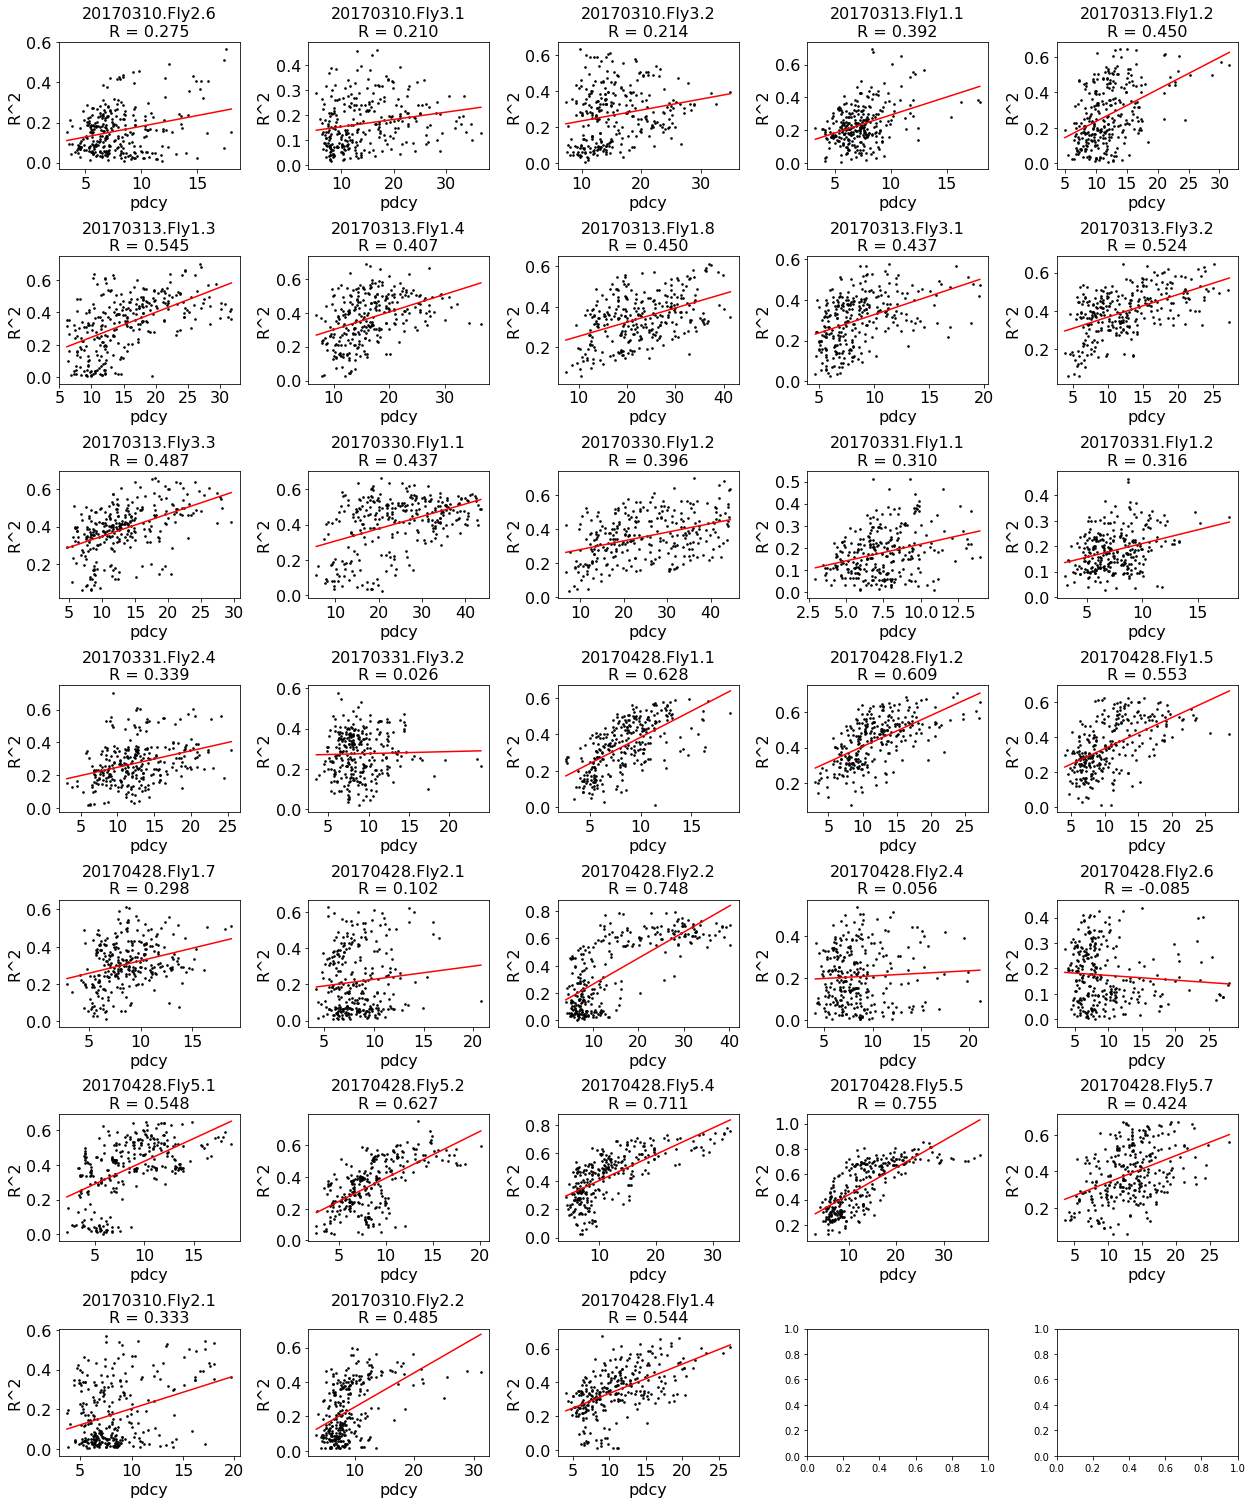

In [29]:
n_row = int(np.ceil(len(trials) / N_COL))
fig_size = (N_COL*AX_SIZE[0], n_row*AX_SIZE[1])

fig, axs = plt.subplots(n_row, N_COL, figsize=fig_size, tight_layout=True)

expls = {}
expl_df_data_low = []
expl_df_data_high = []

rs = []
mean_pdcys = []

for ax, trial in zip(axs.flat, trials):
    print('Calculating periodicity dependence for trial "{}"...'.format(trial.name))
    
    t = trial.dl.t
    ddt_g4d = trial.dl.ddt_g4d
    v_air = trial.dl.v_air
    
    pdcys = []
    r2s = []
    
    # loop over time windows
    for t_start in np.arange(0, t[-1] - WINDOW, STEP):
        
        # get time mask
        t_end = t_start + WINDOW
        mask = (t_start <= trial.dl.t) & (trial.dl.t < t_end)
        
        t_ = t[mask]
        ddt_g4d_ = ddt_g4d[mask]
        v_air_ = v_air[mask]
        
        # get v_air periodicity
        pdcy = periodicity(v_air_)
        
        # get fit R^2 between v_air and ddt_g4d
        vs = {'ddt_g4d': ddt_g4d_}
        xs = make_extended_predictor_matrix(vs, WINDOWS_LIN_FIT, order=['ddt_g4d'])
        
        # remove nans
        valid = (~np.isnan(v_air_)) & (np.all(~np.isnan(xs), axis=1))
        t_ = t_[valid]
        xs = xs[valid]
        v_air_ = v_air_[valid]
        
        rgr = LinearRegression(n_jobs=-1)
        rgr.fit(xs, v_air_)
        r2 = rgr.score(xs, v_air_)
        
        pdcys.append(pdcy)
        r2s.append(r2)
        
        # store examples if desired
        if (pdcy < EXPL_LOW_CUTOFF) or (pdcy >= EXPL_HIGH_CUTOFF):
            key = '{}_{}s'.format(trial.name, t_start)
            predicted = rgr.predict(xs)
            expls[key] = {'t': t_.copy(), 'true': v_air_.copy(), 'predicted': predicted.copy(), 'R2': r2, 'pdcy': pdcy}
            expl_df_data_ = {'trial': trial.name, 't_start': t_start, 'key': key, 'R2': r2, 'pdcy': pdcy}
            
            if pdcy < EXPL_LOW_CUTOFF:
                expl_df_data_low.append(expl_df_data_)
            elif pdcy >= EXPL_LOW_CUTOFF:
                expl_df_data_high.append(expl_df_data_)
        
    ax.scatter(pdcys, r2s, s=7, color='k', lw=0)
    
    # remove nans
    valid = (~np.isnan(pdcys)) * (~np.isnan(r2s))
    pdcys = np.array(pdcys)[valid]
    r2s = np.array(r2s)[valid]
    
    slp, icpt, r, p, _ = linregress(pdcys, r2s)
    
    xs_line = np.array([np.min(pdcys), np.max(pdcys)])
    ys_line = slp*xs_line + icpt
    
    ax.plot(xs_line, ys_line, color='r')
    
    ax.set_xlabel('pdcy')
    ax.set_ylabel('R^2')
    ax.set_title('{0}\nR = {1:.3f}'.format(trial.name, r))
    
    set_font_size(ax, 16)
    
    # store corr. coef and mean pdcy
    rs.append(r)
    mean_pdcys.append(pdcys.mean())

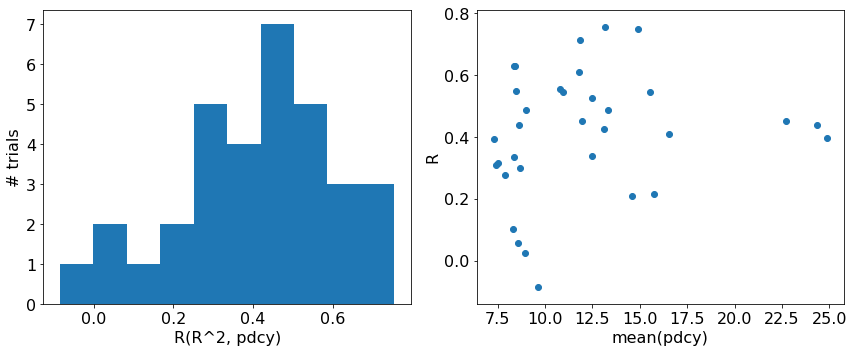

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5), tight_layout=True)

axs[0].hist(rs, bins=10, lw=0)
axs[0].set_xlabel('R(R^2, pdcy)')
axs[0].set_ylabel('# trials')

axs[1].scatter(mean_pdcys, rs)
axs[1].set_xlabel('mean(pdcy)')
axs[1].set_ylabel('R')

for ax in axs:
    set_font_size(ax, 16)

### Examples of trial segments with high and low periodicity

In [31]:
expl_df_low = pd.DataFrame(expl_df_data_low, columns=['trial', 't_start', 'key', 'R2', 'pdcy'])
expl_df_high = pd.DataFrame(expl_df_data_high, columns=['trial', 't_start', 'key', 'R2', 'pdcy'])

In [32]:
expl_df_low

,trial,t_start,key,R2,pdcy
0,20170310.Fly2.6,5.0,20170310.Fly2.6_5.0s,0.030251,4.517790
1,20170310.Fly2.6,6.0,20170310.Fly2.6_6.0s,0.063616,4.825452
2,20170310.Fly2.6,53.0,20170310.Fly2.6_53.0s,0.093705,3.797923
3,20170310.Fly2.6,54.0,20170310.Fly2.6_54.0s,0.084979,4.421287
4,20170310.Fly2.6,56.0,20170310.Fly2.6_56.0s,0.089930,4.830227
5,20170310.Fly2.6,74.0,20170310.Fly2.6_74.0s,0.255992,4.783894
6,20170310.Fly2.6,76.0,20170310.Fly2.6_76.0s,0.212040,4.889573
7,20170310.Fly2.6,140.0,20170310.Fly2.6_140.0s,0.109823,4.569494
8,20170310.Fly2.6,150.0,20170310.Fly2.6_150.0s,0.172776,4.509957
9,20170310.Fly2.6,186.0,20170310.Fly2.6_186.0s,0.044191,3.663356


In [33]:
expl_df_high

,trial,t_start,key,R2,pdcy
0,20170310.Fly3.1,139.0,20170310.Fly3.1_139.0s,0.147593,31.607206
1,20170310.Fly3.1,140.0,20170310.Fly3.1_140.0s,0.191630,32.424347
2,20170310.Fly3.1,141.0,20170310.Fly3.1_141.0s,0.165408,32.770060
3,20170310.Fly3.1,142.0,20170310.Fly3.1_142.0s,0.173790,31.914286
4,20170310.Fly3.1,143.0,20170310.Fly3.1_143.0s,0.196938,33.122538
5,20170310.Fly3.1,144.0,20170310.Fly3.1_144.0s,0.275736,33.419262
6,20170310.Fly3.1,145.0,20170310.Fly3.1_145.0s,0.277051,30.454161
7,20170310.Fly3.1,212.0,20170310.Fly3.1_212.0s,0.053519,28.843604
8,20170310.Fly3.1,215.0,20170310.Fly3.1_215.0s,0.126739,29.212072
9,20170310.Fly3.1,226.0,20170310.Fly3.1_226.0s,0.253622,28.146639


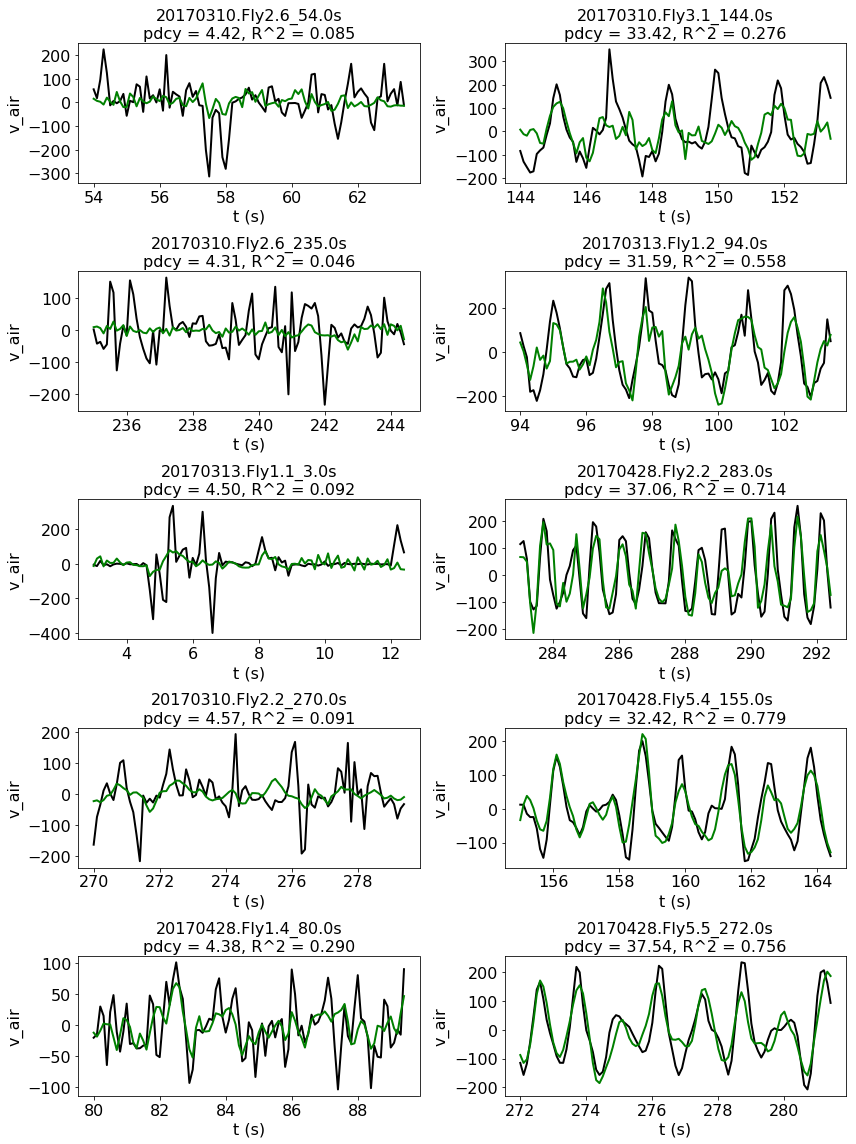

In [35]:
EXPLS_LOW = [
    '20170310.Fly2.6_54.0s',
    '20170310.Fly2.6_235.0s',
    '20170313.Fly1.1_3.0s',
    '20170310.Fly2.2_270.0s',
    '20170428.Fly1.4_80.0s'
]

EXPLS_HIGH = [
    '20170310.Fly3.1_144.0s',
    '20170313.Fly1.2_94.0s',
    '20170428.Fly2.2_283.0s',
    '20170428.Fly5.4_155.0s',
    '20170428.Fly5.5_272.0s',
]

fig, axs = plt.subplots(max(len(EXPLS_LOW), len(EXPLS_HIGH)), 2, figsize=(12, 16), tight_layout=True, squeeze=False)

for (ax_low, ax_high), key_low, key_high in zip(axs, EXPLS_LOW, EXPLS_HIGH):
    
    expl_low = expls[key_low]
    ax_low.plot(expl_low['t'], expl_low['true'], color='k', lw=2)
    ax_low.plot(expl_low['t'], expl_low['predicted'], color='g', lw=2)
    ax_low.set_xlabel('t (s)')
    ax_low.set_ylabel('v_air')
    ax_low.set_title('{0}\npdcy = {1:.2f}, R^2 = {2:.3f}'.format(key_low, expl_low['pdcy'], expl_low['R2']))
    
    expl_high = expls[key_high]
    ax_high.plot(expl_high['t'], expl_high['true'], color='k', lw=2)
    ax_high.plot(expl_high['t'], expl_high['predicted'], color='g', lw=2)
    ax_high.set_xlabel('t (s)')
    ax_high.set_ylabel('v_air')
    ax_high.set_title('{0}\npdcy = {1:.2f}, R^2 = {2:.3f}'.format(key_high, expl_high['pdcy'], expl_high['R2']))

for ax in axs.flat:
    set_font_size(ax, 16)